# 📡 Характеристика канала между RFID считывателем и меткой
В ноутбуке представлены результаты моделирования канала для случая, когда RFID считыватель закреплён на движущимся равномерно и прямолинейно БПЛА, а метки неподвижно лежат на земеле на таком расстоянии, что между ними никогда не возникает коллизий.
В ноутбуке приведены результаты для нескольких сценариев:
1) БПЛА и метка неподвижны друг относительно друга (дрон завис в воздухе);
2) Дрон движется, метка принимает только прямой луч (дрон над полем без препятствий);
3) Дрон движется, на метку попадает прямой и отражённый лучи (дрон летит вдоль стены, от которой происходит отражение).

Картинки результатов моделирования сохраняются в директории `experiments/result_images/channel`.

In [1]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np

from pysim.models.rfid import channel
from utility.channel_helper import(
    find_zones
)
from utility.graphs_style import (
    GraphConsts, get_color,
    savefig, setup_matplotlib,
)
import pysim.models.rfid.epcstd as epc

In [2]:
# Автоматически применить часть стилей для графиков
%matplotlib inline
setup_matplotlib()

## 🔧 Параметры моделирования
Для работы модели требуется определить положение метки и считывателя в трёхмерном пространстве с помощью декартовых координат. В папке `experiments` представлена интерактивная трёмерная python-модель для визуализации местоположений всех моделируемых объектов, направлений их движений и антенн, а также прочие вспомогательные величины. Перед работой с данным блокнотом рекомендуется ознакомиться с 3D-визуализацией. 
* Симуляция проходит в трёхмерном пространстве. Это значение хранит константа `DIMENSION_OF_SPACE`. Соответственно, все координаты, вектора скорости и направления антенн определяются как трёхмерные массивы координат типа `np.array`;
* Точка `(0;0;0)` находится у основания стены;
* Ось абсцисс `(OX)` направлена перпендикулярно движению БПЛА со считывателем;
* Ось ординат `(OY)` направлена параллельно движению БПЛА;
* Ось аппликат `(OZ)` направлена вдоль стены вверх;
* Стена (если есть) находится в плоскости `YOZ`;

Требования:
1) Положение считывателя и метки указывается как `np.array((x, y, z))`, где x, y, z - координаты в метрах в начале моделирования;
2) Координаты векторов направлений антенн считывателя и метки должны быть отнормированными;

In [3]:
DIRECTORY = 'channel' # Название директории, в которой будут сохраняться изображения

### 🌍 Параметры окружающей среды

In [4]:
FREQUENCY = 860_000_000              # Гц
SPEED_OF_LIGHT = 299_792_458         # м/с
WAVELEN = SPEED_OF_LIGHT / FREQUENCY
THERMAL_NOISE = -114.0               # dBm
DIMENSION_OF_SPACE = 3

MINIMUM_DISTANCE = -15  # Минимальное расстояние по земле, на котором будет рассматриваться система, м
MAXIMUM_DISTANCE = 15   # Максимальное расстояние по земле, на котором будет рассматриваться система, м
D_SHIFT = 5             # Вычитаемое из переменных DISTANCE, чтобы получить более короткий отрезок, м
GRID_STEP = 200         # Шаг, с которым строятся графики

# Эффект Доплера ----------------------------
DOPPLER_LINES_COUNT = 5 # Количество вычисляемых кривых для эффекта Доплера
MINIMUM_TIME = 0
MAXIMUM_TIME = 0.2

# Поляризация--------------------------------
VERTICAL_POLARIZATION = 0.0
HORIZONTAL_POLARIZATION = 1.0
CIRCULAR_POLARIZATION = 0.5

# Характеристики поверхности отражения-------
PERMITTIVITY = 15
CONDUCTIVITY = 0.03

REFLECTION = channel.reflection
RADIATION_PATTERN = channel.rp_dipole

### 📶 Параметры RFID считывателя

In [5]:
DEFAULT_SPEED = 10               # Метров в секунду
READER_POS = np.array((5, 0, 5)) # Высота 5 метров
READER_ANTENNA_DIRECTION = channel.normalize(np.array((0, 0, -1)))
READER_POLARIZATION = CIRCULAR_POLARIZATION # Поляризация антенны
READER_GAIN = 8            # Усиление антенны
READER_CABLE_LOSS = -2.0   # dBm
READER_NOISE = -80.0       # dBm
READER_TX_POWER = 31.5     # dBm
READER_SENSITIVITY = -80.0 # dBm

# Протокол-----------------------------
DR = epc.DivideRatio.DR_8
RTCAL_MUL = 2.75
TRCAL_MUL = 1.95 # TODO: унифицировать везде множители

### 🏷️ Параметры RFID метки

In [6]:
TAG_POS = np.array((5.0, 0, 0))                # Метка на земле
TAG_ANTENNA_DIRECTION = channel.normalize(((0, 0, 1.0)))  # Направление антенны метки (вверх)
TAG_POLARIZATION = HORIZONTAL_POLARIZATION     # Поляризация антенны
TAG_SENSITIVITY = -18.0       # dBm
TAG_GAIN = 2.0                # Усиление антенны
TAG_BACKSCATTER_LOSS = -10.0  # dBm

## 📈 Коэффициент отражения
* Играет роль при двухлучевом распространения сигнала, так как в однолучевом случае отсутствует отражённая компонента;
* Зависит от диэлектрической проницаемости `PERMITTIVITY` и проводимости `CONDUCTIVITY` поверхности, от которой отражается луч радиосигнала, а также от его угла падения.


#### Формула для расчёта

Коэффициент отражения $R$ выражается через угол падения $\varphi$ и комплексную диэлектрическую проницаемость:

$$
R = \frac{\sin \varphi - \sqrt{C}}{\sin \varphi + \sqrt{C}},
$$

где

- для **горизонтально поляризованной компоненты**:  
  $C = \eta - \cos^2 \varphi$,

- для **вертикально поляризованной компоненты**:  
  $C = \frac{\eta - \cos^2 \varphi}{\eta^2}$,

а также

- $\eta = \varepsilon_r(f) - j 60 \lambda \sigma(f)$ — комплексная диэлектрическая проницаемость поверхности;
- $\varepsilon_r(f)$ — относительная диэлектрическая проницаемость поверхности на частоте $f$ (табличное значение);
- $\sigma(f)$ — проводимость поверхности (табличное значение);
- $j$ — мнимая единица ($j^2 = -1$).

In [7]:
# Общие параметры для графиков в разделе 'Коэффициент отражения'
PARAMS_1_BEAM = {'color': get_color(0), 'linestyle': '-.',
           'marker': 'X', 'markevery': 20, 'label': 'Канал без отражений'}
PARAMS_VERT = {'color': get_color(0.2), 'linestyle': '-', 'marker': 'v',
           'markevery': GraphConsts.MARKEVERY, 'label': 'Вертикальная поляризация'}
PARAMS_CIRC = {'color': get_color(0.5), 'linestyle': '--', 'marker': 'o',
            'markevery': GraphConsts.MARKEVERY, 'label': 'Круговая поляризация'}
PARAMS_HOR = {'color': get_color(0.8), 'linestyle': '-', 'marker': '^',
            'markevery': GraphConsts.MARKEVERY, 'label': 'Горизонтальная поляризация'}
PARAMS_HOR_SPEED = {'color': get_color(0), 'linestyle': ':', 'marker': '^',
            'markevery': GraphConsts.MARKEVERY,
            'label': 'Горизонтальная поляризация\nс эффектом Доплера'}

In [8]:
def get_reflection(
    incidence_angle: float,
    pol: float,
    permittivity: float = PERMITTIVITY,
    conductivity: float = CONDUCTIVITY, 
    wavelen: float = WAVELEN
) -> float:
    """
    Рассчитать коэффициент отражения радиосигнала от поверхности.

    Args:
        incidence_angle: угол падения сигнала (в радианах)
        pol: поляризация сигнала (принимает значения: 0, 0.5, 1)
        permittivity: диэлектрическая проницаемость поверхности
        conductivity: проводимость поверхности
        wavelen: длина волны сигнала

    Returns:
        абсолютное значение коэффициента отражения
    """
    return abs(
        channel.reflection(
            cosine=np.cos(incidence_angle),
            polarization=pol,
            permittivity=permittivity,
            conductivity=conductivity,
            wavelen=wavelen
        )
    )

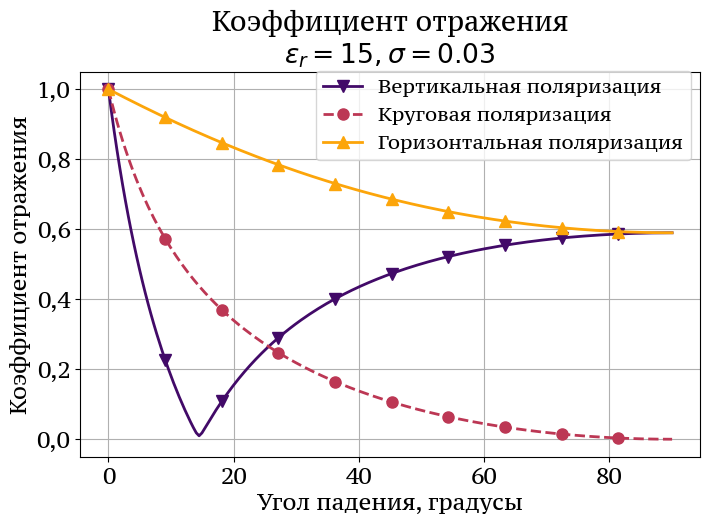

In [9]:
def plot_reflection(
    image_name: str = 'Reflection coefficient', save_fig: bool = False
) -> None:
    """
    Нарисовать графики коэффициента отражения в зависимости от 
    угла падения сигнала для разных типов поляризаций антенны считывателя.
    
    Args:
        image_name (str): имя файла без расширения
        save_fig: сохранить ли изображение
    """
    # Получение результатов
    oa_axis = np.linspace(0, 90, GRID_STEP)  # Угол падения, градусы
    reflection_vert = [
        get_reflection(channel.deg2rad(incidence_angle), VERTICAL_POLARIZATION)
        for incidence_angle in oa_axis
    ]
    reflection_circ = [
        get_reflection(channel.deg2rad(incidence_angle), CIRCULAR_POLARIZATION)
        for incidence_angle in oa_axis
    ]
    reflection_hor = [
        get_reflection(channel.deg2rad(incidence_angle),
                       HORIZONTAL_POLARIZATION)
        for incidence_angle in oa_axis
    ]

    # Оформление графиков
    fig, ax = plt.subplots(figsize=GraphConsts.FIGSIZE, nrows=1, ncols=1)
    ax.set_title('Коэффициент отражения\n' + 
                  fr'$\epsilon_r = {PERMITTIVITY}, \sigma = {CONDUCTIVITY}$')
    ax.set_xlabel('Угол падения, градусы')
    ax.set_ylabel('Коэффициент отражения')
    ax.plot(oa_axis, reflection_vert, **PARAMS_VERT)
    ax.plot(oa_axis, reflection_circ, **PARAMS_CIRC)
    ax.plot(oa_axis, reflection_hor, **PARAMS_HOR)
    ax.grid()
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

    if save_fig:
        savefig(name=image_name, directory=DIRECTORY)


# Вызов функции
plot_reflection(save_fig=True)

## 📉 Расчет затуханий

Для канала от считывателя к метки и обратно. Для расчета затуханий используется функция `pathloss_model` из модуля `channel.py`, но здесь описаны более удобные обертки.

#### Формула для расчёта затуханий в общем случае:

$$
A_{\text{pl}} = |r(t)|^2 = \left( \frac{\lambda}{4\pi} \right)^2 
\left| \sum_{i=0}^N \frac{R_i \Gamma_i}{d_i} 
e^{-j k (d_i - v t \cos \psi_i)} \right|^2
$$

#### Обозначения:
- $r(t)$ - величина принятого сигнала в зависимости от времени $t$;
- $\lambda$ — длина волны;
- $R_i$ — коэффициент затухания, вызванного отражением $i$-го луча;
- $\Gamma_i = \Gamma_i^{(r)} \Gamma_i^{(t)}$ — коэффициент затухания, вызванного направлениями диаграмм направленности считывателя $(r)$ и метки $(t)$ для $i$-го луча; отражает ослабление сигнала, определяемое направленными свойствами передающей и принимающей антенн;
- $d_i$ — длина $i$-го луча от передатчика до приёмника;
- $k = \frac{2\pi}{\lambda}$ — волновое число;
- $v$ — скорость относительного движения (например, считывателя или метки);
- $t$ — момент времени начала наблюдения;
- $\psi_i$ — угол между волновым вектором $k$ и направлением движения для $i$-го луча;
- $j$ — мнимая единица ($j^2 = -1$);
- $N$ — количество лучей (включая прямой и отражённые).

Здесь и далее надстрочный индекс используется для обозначения устройства:  
- $(r)$ — для считывателя,  
- $(t)$ — для метки;  

#### Диаграммы направленностей антенн
Во всех моделях для упрощения принимается, что и у считывателя, и у метки - простые дипольные антенны с такой диаграммой направленности:
$$
\Gamma(\theta) = \left| \frac{\cos \left( \frac{\pi}{2} \sin \theta \right)}{\cos \theta} \right|.
$$

где:
- $\theta$ — угол между направлением главного луча антенны и направлением прихода сигнала;
- $\Gamma(\theta)$ — относительная амплитуда излучения в направлении $\theta$.

In [10]:
def get_free_space_pathloss(y: float, v: float = 0, t: float = 0) -> float:
    """
    Расчёт затухания в канале без отражений (прямой путь).

    Args:
        y: координата считывателя вдоль оси OY (в метрах)
        v: скорость движения считывателя вдоль оси OY (м/с)
        t: время с момента начала передачи (с)

    Returns:
        затухание в дБ
    """
    return channel.pathloss_model(
        time=t,
        wavelen=WAVELEN, 
        # Параметры считывателя: ---------------------------
        tx_pos=np.array((READER_POS[0], y, READER_POS[2])), # Координата y изменяется
        tx_antenna_dir=READER_ANTENNA_DIRECTION,
        tx_rp=RADIATION_PATTERN,
        tx_velocity=np.array((0, v, 0)), # Движение только по оси OY
        # Параметры метки: ---------------------------------
        rx_pos=TAG_POS,
        rx_antenna_dir=TAG_ANTENNA_DIRECTION,
        rx_rp=RADIATION_PATTERN,
        rx_velocity=np.zeros(DIMENSION_OF_SPACE),
        # ---------------------------------------------------
        log=True
    )

In [11]:
def get_pathloss(
    y: float, pol: float, v: float = DEFAULT_SPEED, t: float = 0.1
) -> float:
    """
    Расчёт затухания в двухлучевом канале (с отражением от стены).
    Значения затухания будут разными для каналов от считывателя к метке
    и обратно только из-за поляризации, так как от нее зависит
    коэффициент отражения. Все остальное - симметрично.

    Args:
        y: координата считывателя вдоль оси OY
        pol: поляризация сигнала (принимает значения: 0, 0.5, 1)
        v: скорость считывателя вдоль оси OY
        t: время с момента начала передачи

    Returns:
        затухание в dB
    """
    return channel.pathloss_model(
        time=t,
        wavelen=WAVELEN, 
        # Параметры считывателя: ---------------------------
        tx_pos=np.array((READER_POS[0], y, READER_POS[2])), # Координата y изменяется
        tx_antenna_dir=READER_ANTENNA_DIRECTION,
        tx_rp=RADIATION_PATTERN,
        tx_velocity=np.array((0, v, 0)), # Движение только по оси OY
        # Параметры метки: ---------------------------------
        rx_pos=TAG_POS,
        rx_antenna_dir=TAG_ANTENNA_DIRECTION,
        rx_rp=RADIATION_PATTERN,
        rx_velocity=np.zeros(DIMENSION_OF_SPACE),
        # Параметры отражения: -----------------------------
        tx_polarization=pol,
        ground_reflection=REFLECTION, 
        conductivity=CONDUCTIVITY, 
        permittivity=PERMITTIVITY,
        # ---------------------------------------------------
        log=True
    )

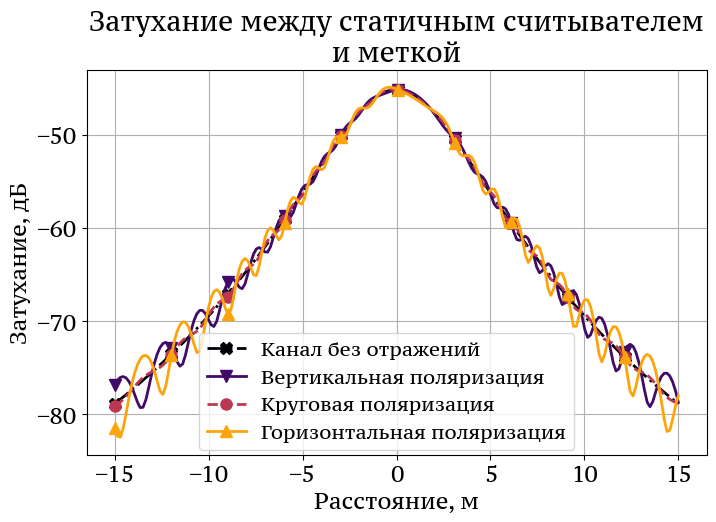

In [12]:
def plot_pathlosses(
    image_name: str = 'Static path loss', save_fig: bool = False
) -> None:
    """
    Построение графиков затухания сигнала для разных поляризаций.
    Под ox_axis понимается ось абсцисс создаваемого графика.

    Args:
        image_name: имя файла для сохранения (без расширения)
        save_fig: сохранить ли изображение
    """
    # Получение результатов
    ox_axis = np.linspace(MINIMUM_DISTANCE, MAXIMUM_DISTANCE, GRID_STEP)  # Расстояние, м    
    free_space_pathloss = [get_free_space_pathloss(x, 0, 0) for x in ox_axis]
    pass_loss_vert = [get_pathloss(x, pol=VERTICAL_POLARIZATION) for x in ox_axis]
    pass_loss_circ = [get_pathloss(x, pol=CIRCULAR_POLARIZATION) for x in ox_axis]
    pass_loss_hor = [get_pathloss(x, pol=HORIZONTAL_POLARIZATION) for x in ox_axis]

    # Оформление графиков
    fig, ax = plt.subplots(figsize=GraphConsts.FIGSIZE, nrows=1, ncols=1)
    ax.set_title('Затухание между статичным считывателем\nи меткой')
    ax.set_xlabel('Расстояние, м')
    ax.set_ylabel('Затухание, дБ')
    ax.plot(ox_axis, free_space_pathloss, **PARAMS_1_BEAM)
    ax.plot(ox_axis, pass_loss_vert, **PARAMS_VERT)
    ax.plot(ox_axis, pass_loss_circ, **PARAMS_CIRC)
    ax.plot(ox_axis, pass_loss_hor, **PARAMS_HOR)
    ax.grid()
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.1))

    if save_fig:
        savefig(name=image_name, directory=DIRECTORY)


# Вызов функции
plot_pathlosses(save_fig=True)

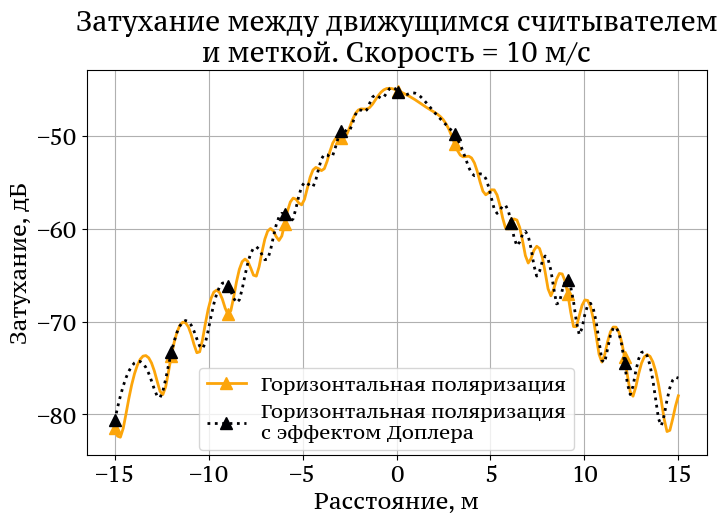

In [13]:
def plot_pathloss_with_doppler(
    speed: float = DEFAULT_SPEED,
    t: float = 1.0,
    image_name: str = 'Dinamic path loss',
    save_fig: bool = False
) -> None:
    """
    Построение графика затухания с учётом эффекта Доплера.

    Args:
        speed: скорость считывателя (км/ч)
        t: время (сек)
        image_name: имя файла (без расширения)
        save_fig: сохранить ли изображение
    """
    # Получение результатов
    ox_axis = np.linspace(MINIMUM_DISTANCE, MAXIMUM_DISTANCE, GRID_STEP)  # Расстояние, м 
    pass_loss_hor = [get_pathloss(x, HORIZONTAL_POLARIZATION) for x in ox_axis]
    pass_loss_hor_speed = [
        get_pathloss(
            x, HORIZONTAL_POLARIZATION, v=channel.kmph2mps(speed), t=t
        ) for x in ox_axis
    ]
    
    # Оформление графиков
    fig, ax = plt.subplots(figsize=GraphConsts.FIGSIZE, nrows=1, ncols=1)
    ax.set_title(f'Затухание между движущимся считывателем\nи меткой. Скорость = {speed} м/с')
    ax.set_xlabel("Расстояние, м")
    ax.set_ylabel("Затухание, дБ")
    ax.plot(ox_axis, pass_loss_hor, **PARAMS_HOR)
    ax.plot(ox_axis, pass_loss_hor_speed, **PARAMS_HOR_SPEED)
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.1))
    ax.grid()

    if save_fig:
        savefig(name=image_name, directory=DIRECTORY)


# Вызов функции
plot_pathloss_with_doppler(speed=DEFAULT_SPEED, t=1.0, save_fig=True)

## 📶 Расчет мощностей сигналов
Пусть $P_{tx}^{(r)}$ — излучаемая мощность считывателя, $G^{(r)}$ — усиление антенны считывателя.  
Тогда эффективная изотропная излучаемая мощность (EIRP) вычисляется по формуле:

$$
EIRP = P_{tx}^{(r)} G^{(r)}.
$$

Надстрочный индекс используется для обозначения устройства, **которое излучает мощность**:  
- $(r)$ — для считывателя (от reader);  
- $(t)$ — для метки (от tag);

Подстрочный индекс указывает **направление передачи**:
- $tx$ — для передачи (от transmission);
- $rx$ — для приёма (от reception);  

При распространении сигнала от считывателя к метке сигнал испытывает затухание $A_{\text{pl}}^{reader-to-tag}$, зависящее от состояния радиоканала и взаимного расположения считывателя и метки. Антенны устройств могут иметь различную поляризацию, что ведёт к дополнительным потерям $A_{\text{pol}}$. Пусть усиление антенны метки — $G^{(t)}$. Тогда мощность сигнала, принимаемого меткой:

$$
P_{rx}^{(t)} = P_{tx}^{(r)} G^{(r)} A_{\text{pl}}^{reader-to-tag} A_{\text{pol}} G^{(t)}.
$$

Если эта мощность меньше чувствительности метки $P_{sensitivity}^{(t)}$, то метка не включится и не сможет взаимодействовать со считывателем. Если мощность достаточна, метка передаст свой ответ за счёт модуляции отражённого сигнала. Его мощность будет:

$$
P_{tx}^{(t)}.
$$

Так как при этом возникают дополнительные энергетические потери (например, на модуляцию), равные $A_{\text{bs}}$, то связь между принятой и переданной меткой мощностью:

$$
P_{tx}^{(t)} = P_{rx}^{(t)} A_{\text{bs}}.
$$
То есть метка излучает меньшую мощность по сравнению с той, что она приняла.

В итоге в конце процесса обмена данными между считывателем и меткой мощность сигнала, принятого считывателем, вычисляется по формуле:

$$
P_{rx}^{(r)} = P_{tx}^{(t)} G^{(t)} A_{\text{bs}} A_{\text{pl}}^{(tag-to-reader)} A_{\text{pol}} G^{(r)}.
$$

> 💡 В общем случае потери на прямом (от считывателя к метке) и обратном (от метки к считывателю) пути могут отличаться.  
Это происходит из-за различий в поляризации (считыватели часто используют круговую, а метки — линейную), а также из-за коэффициента отражения (в текущем случае - от стены).

> ‼️ Так как в коде все вычисления мощности делаются для дециБелл милливат (dBm), то во всех формулах умножение заменяется сложением.

In [14]:
def get_tag_rx(y: float, v: float, t: float, power: float = READER_TX_POWER) -> float:
    """Вычислить мощность сигнала, принятого меткой (в dBm)."""
    path_loss = get_pathloss(y, READER_POLARIZATION, v, t)
    pol_loss = 0 if READER_POLARIZATION == TAG_POLARIZATION else -3.0
    gain = READER_GAIN + TAG_GAIN
    return power + path_loss + pol_loss + gain + READER_CABLE_LOSS

In [15]:
def get_tag_tx(power: float) -> float:
    """Вычислить мощность сигнала, отраженного меткой (в dBm)."""
    return power + TAG_BACKSCATTER_LOSS

In [16]:
def get_reader_rx(y: float, v: float, t: float, power: float) -> float:
    """Вычислить мощность сигнала, принятого считывателем (в dBm)."""
    path_loss = get_pathloss(y, TAG_POLARIZATION, v, t)
    pol_loss = 0 if READER_POLARIZATION == TAG_POLARIZATION else -3.0
    gain = READER_GAIN + TAG_GAIN
    return power + path_loss + pol_loss + gain + READER_CABLE_LOSS

Для определения зон, в которых метка получает сигнал, выше уровня ее чувствительности используется функция `find_high_zones()`, которая возвращает набор интервалов, внутри которых значение функции больше граничного значения.

Зоны, где метка отключена: [(np.float64(-15.0), np.float64(-4.4472361809045236)), (np.float64(4.597989949748744), np.float64(15.0))]


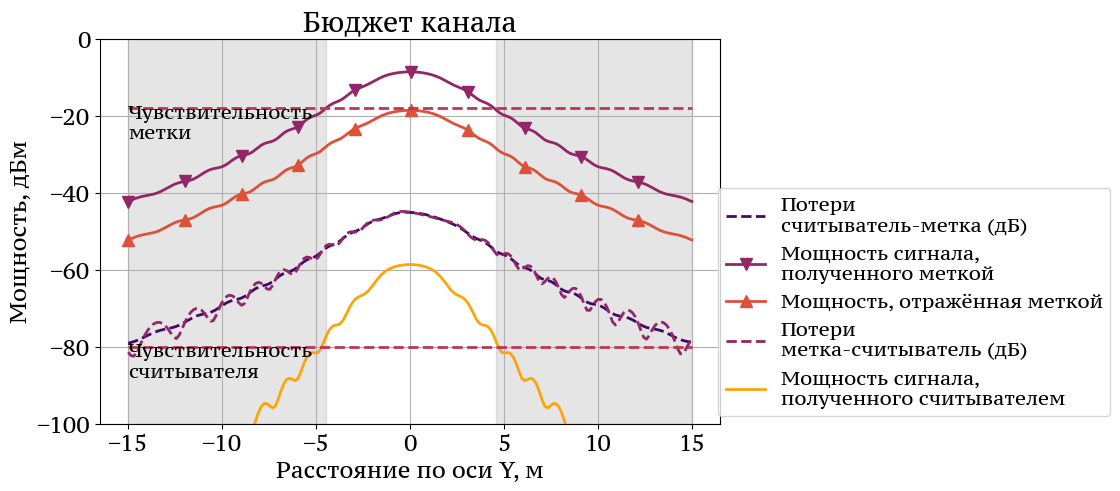

In [17]:
def plot_budget(
    image_name: str = 'Channel budget', save_fig: bool = False
) -> None:
    """
    Построение графиков бюджета канала между считывателем и меткой.
    Параметры окружающей среды:
      - В системе присутстсвует отражённый (второй) луч
      - Считыватель неподвижен относительно метки
    Под ox_axis понимается ось абсцисс создаваемого графика.

    Args:
        image_name: имя файла для сохранения (без расширения)
        save_fig: сохранить ли изображение
    """
    # Получение результатов
    ox_axis = np.linspace(MINIMUM_DISTANCE, MAXIMUM_DISTANCE, GRID_STEP)
    reader2tag_pl = [get_pathloss(x, READER_POLARIZATION) for x in ox_axis]
    tag_accepted_power = [get_tag_rx(x, v=0, t=0) for x in ox_axis]
    tag_radiated_power = [get_tag_tx(power) for power in tag_accepted_power]
    tag2reader_pl = [get_pathloss(x, TAG_POLARIZATION) for x in ox_axis]
    reader_accepted_power = [get_reader_rx(x, v=0, t=0, power=tag_power)
                             for (x, tag_power) in zip(ox_axis, tag_radiated_power)]

    # Ограничения осей
    y_max = 0
    y_min = -100

    # Оформление графиков---------------------------------------------------------
    # Получение результатов
    fig, ax = plt.subplots(figsize=GraphConsts.FIGSIZE, nrows=1, ncols=1)
    ax.plot(ox_axis, reader2tag_pl, label='Потери\nсчитыватель-метка (дБ)',
        linestyle='--', color=get_color(0.2))
    ax.plot(ox_axis, tag_accepted_power, label='Мощность сигнала,\nполученного меткой',
        linestyle='-', marker='v', markevery=GraphConsts.MARKEVERY,
        color=get_color(0.4))
    ax.plot(ox_axis, tag_radiated_power, label='Мощность, отражённая меткой',
        linestyle='-', marker='^', markevery=GraphConsts.MARKEVERY,
        color=get_color(0.6))
    ax.plot(ox_axis, tag2reader_pl, label='Потери\nметка-считыватель (дБ)',
        linestyle='--', color=get_color(0.4))
    ax.plot(ox_axis, reader_accepted_power, label='Мощность сигнала,\nполученного считывателем',
        color=get_color(0.8))

    # Линии чувствительности метки и считывателя
    ax.hlines(y=TAG_SENSITIVITY, xmin=ox_axis[0], xmax=ox_axis[-1], 
          colors=get_color(0.5), linestyles='--')
    ax.hlines(y=READER_SENSITIVITY, xmin=ox_axis[0], xmax=ox_axis[-1], 
          colors=get_color(0.5), linestyles='--')

    # Области, в которых метка выключена
    tag_off_intervals = find_zones(ox_axis, tag_accepted_power, TAG_SENSITIVITY, use_upper=False)
    print(f'Зоны, где метка отключена: {tag_off_intervals}')
    for interval in tag_off_intervals:
        ax.add_patch(patches.Rectangle(xy=(interval[0], y_min), 
            width=(interval[1] - interval[0]), 
            height=(y_max - y_min),
            fill=True, color='gray', alpha=0.2))

    ax.text(x=MINIMUM_DISTANCE, y=TAG_SENSITIVITY-8,
            s='Чувствительность\nметки', fontsize=GraphConsts.LEGEND_FONTSIZE,
            fontdict={'style': 'italic'})
    ax.text(x=MINIMUM_DISTANCE, y=READER_SENSITIVITY-8,
            s='Чувствительность\nсчитывателя', fontsize=GraphConsts.LEGEND_FONTSIZE,
            fontdict={'style': 'italic'})

    # Оси и легенда
    ax.set_ylim((y_min, y_max))
    ax.grid()
    ax.set_xlabel('Расстояние по оси Y, м')
    ax.set_ylabel('Мощность, дБм')
    ax.tick_params(axis='both', which='major')

    handles, labels = ax.get_legend_handles_labels()
    patch = patches.Patch(color='grey', alpha=0.5)
    handles.append(patch)
    fig.legend(bbox_to_anchor=(1.4, 0.6))
    ax.set_title('Бюджет канала')

    if save_fig:
        savefig(name=image_name, directory=DIRECTORY)

# Вызов функции
plot_budget(save_fig=True)

### 🌀 Учёт эффекта Доплера

Эффект Доплера сильно влияет на затухание и, как следствие, на мощность сигналов, принятых меткой и считывателем. 

В следующем примере рассмотрено, как меняется мощность при увеличении времени, прошеднего со включения считывателя. Считыватель будет двигаться со скоростью `DEFAULT_SPEED`.

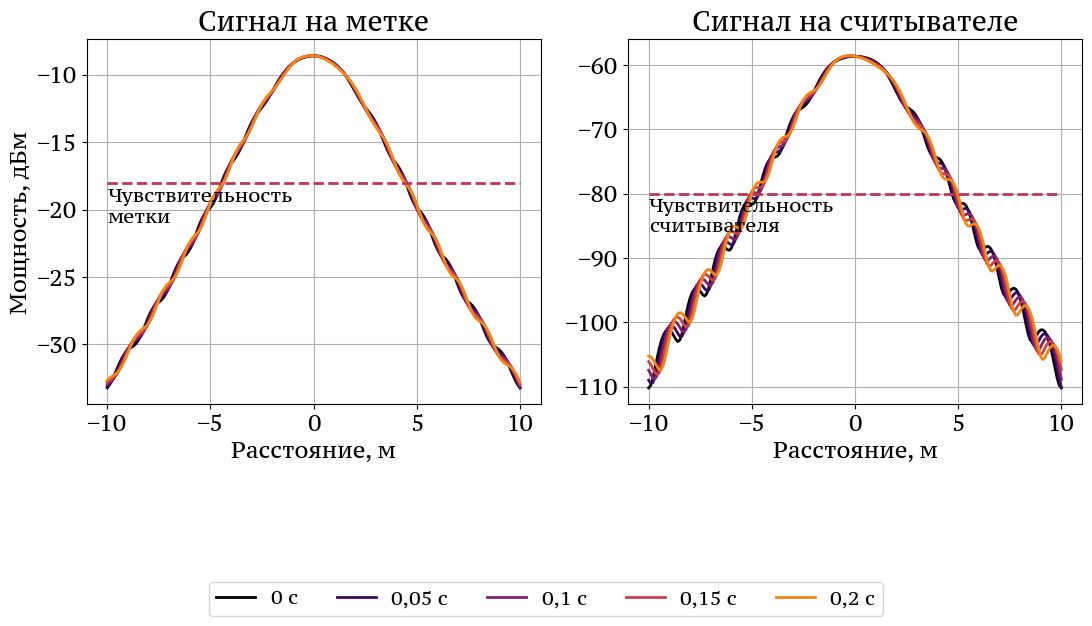

In [18]:
def plot_received_power_doppler(
    image_name: str = 'Power Dopler', save_fig: bool = False
) -> None:
    """
    Нарисовать графики мощностей сигналов, принятых меткой и считывателем,
    с учетом эффекта Допера.
    Переменная t в этих графиках — это время, прошедшее с начала движения считывателя.
    
    Args:
        image_name (str): имя файла без расширения
        save_fig: сохранить ли изображение
    """
    # Задание областей моделирования
    ox_axis = np.linspace(
        MINIMUM_DISTANCE+D_SHIFT, MAXIMUM_DISTANCE-D_SHIFT, GRID_STEP
    )
    times = np.linspace(MINIMUM_TIME, MAXIMUM_TIME, DOPPLER_LINES_COUNT)
    v = channel.kmph2mps(DEFAULT_SPEED)
    fig, (ax0, ax1) = plt.subplots(
        figsize=(GraphConsts.FIGSIZE[0]*1.4, GraphConsts.FIGSIZE[1]), nrows=1, ncols=2
    ) # Растяжение области построения графиков, чтобы влезло 2 изображения
    
    for i, t in enumerate(times):
        # Получение результатов
        tag_accepted_power = [get_tag_rx(x, v, t) for x in ox_axis]
        tag_radiated_power = [get_tag_tx(power) for power in tag_accepted_power]
        reader_accepted_power = [get_reader_rx(x, v, t, power)
                                 for (x, power) in zip(ox_axis, tag_radiated_power)]
        # Построение кривых
        color = get_color(i / (len(times) * 1.1))
        ax0.plot(ox_axis, tag_accepted_power, label=f'{t:n} с', color=color)
        ax1.plot(ox_axis, reader_accepted_power, color=color)

    # Оформление графиков
    ax0.set_ylabel('Мощность, дБм')
    for ax in (ax0, ax1):
        ax.grid()        
        ax.set_xlabel('Расстояние, м')
    ax0.set_title('Сигнал на метке')
    ax1.set_title('Сигнал на считывателе')
    ax0.hlines(y=TAG_SENSITIVITY, xmin=ox_axis[0], xmax=ox_axis[-1], 
               colors=get_color(0.5), linestyles='--')
    ax1.hlines(y=READER_SENSITIVITY, xmin=ox_axis[0], xmax=ox_axis[-1], 
               colors=get_color(0.5), linestyles='--')
    ax0.text(x=ox_axis[0], y=TAG_SENSITIVITY - 3, s='Чувствительность\nметки',
         fontsize=GraphConsts.LEGEND_FONTSIZE, style='italic')
    ax1.text(x=ox_axis[0], y=READER_SENSITIVITY - 6, s='Чувствительность\nсчитывателя',
         fontsize=GraphConsts.LEGEND_FONTSIZE, style='italic')
    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', 
               bbox_to_anchor=(0.5, -0.28), ncol=6) 
    plt.tight_layout()

    if save_fig:
        savefig(name=image_name, directory=DIRECTORY)

plot_received_power_doppler(save_fig = True)

## 🧩 Расчет битовой ошибки

Расчёт битовой ошибки и исследование её зависимости от параметров канала и эффекта Доплера.

Для расчета BER нужно знать отношение "сигнал-шум" (SNR) $\gamma$. 
Для более точных результатов лучше вместо простого SNR использовать величину, учитывающую количество принятой энергии на бит $\acute{\gamma}$:

$$
\acute{\gamma} = \frac{m E_s}{N_0} \cos^2 \phi_s,
$$
где:

- $m$ - число символов на бит в ответах метки (1, 2, 4 или 8);
- $E_s$ - энергия на один символ;
- $N_0/2$ - спектральная плотность шума;
- $\phi_s$ - разность фазы сигнала и фазы приема.

Отношение $E_s / N_0$ можно выразить через SNR $\gamma$, длительность символа
$T_s$ и ширину полосы $B$ как $E_s / N_0 = \gamma T_s B$. Величину $\phi_s$
можно оценить как $\frac{1}{\sqrt{\gamma T_{pr} B}}$, где $T_{pr}$ - длина
преамбулы. Подставляя в форумулу, получаем:

$$
\acute{\gamma} \approx m \gamma T_s B \cos^2 \frac{1}{\sqrt{\gamma T_{pr} B}}
$$


Самая простая формула для расчета BER - канал AWGN. В нем BER рассчитывается так:

$$
P_{er} = 2 Q(\acute{\gamma}) [1 - Q(\acute{\gamma})]
$$

Эта формула слишком оптимистична, поэтому для расчета BER будем использовать формулу, 
полученную усреднением BER для канала AWGN по распределению Рэлея:

$$
BER = \frac{1}{2} - 
      \frac{1}{\sqrt{1 + \frac{2}{\acute{\gamma}}}} + 
      \frac{2}{\pi} \frac{\arctan{\sqrt{1 + \frac{2}{\acute{\gamma}}}}}{\sqrt{1 + \frac{2}{\acute{\gamma}}}}.
$$

In [19]:
NOISE = channel.to_log(
    value=(channel.from_log(READER_NOISE, dbm=True) + channel.from_log(THERMAL_NOISE, dbm=True)),
    dbm=True
)

def get_snr(rx: float, m: int, trcal: float, trext: bool = False,
            dr: epc.DivideRatio = DR) -> float:
    """Вычислить SNR на бит с поправкой на синхронизацию."""
    snr = channel.snr(power=rx, noise=NOISE)
    preamble = epc.get_preamble(m, trcal, trext, dr)
    return channel.snr_full(
        snr=snr, 
        miller=m, 
        symbol=(1 / epc.get_blf(dr, trcal)),
        preamble=preamble
    )


### 🛠️ Подготовка параметров для расчёта BER

Расчёт BER для разных Tari, M и DR.

Чтобы немного упростить вывод, не будем рассматривать все возможные комбинации 
`Tari`, `M`, `DR`, а выделим шесть разных наборов:

- `Tari = 6.25, M = 1, DR = 64/3, TRext = False` (самый быстрый)
- `Tari = 6.25, M = 4, DR = 64/3, TRext = False`
- `Tari = 12.5, M = 4, DR = 64/3, TRext = False`
- `Tari = 12.5, M = 4, DR = 8, TRext = False`
- `Tari = 25.0, M = 4, DR = 8, TRext = True`
- `Tari = 25.0, M = 8, DR = 8, TRext = True` (самый медленный)

In [20]:
SERIES = [
    [6.25, epc.TagEncoding.FM0, epc.DivideRatio.DR_643],
    [6.25, epc.TagEncoding.FM0, epc.DivideRatio.DR_8],
    [6.25, epc.TagEncoding.M4, epc.DivideRatio.DR_643],
    [12.5, epc.TagEncoding.M4, epc.DivideRatio.DR_643],
    [12.5, epc.TagEncoding.M4, epc.DivideRatio.DR_8],
    [25.0, epc.TagEncoding.M4, epc.DivideRatio.DR_8],
    [25.0, epc.TagEncoding.M8, epc.DivideRatio.DR_8]
]
SERIES_SIZE = len(SERIES)
SERIES_MARKERS = ["o", "v", "^", "X", "D", "*", "s"]
SERIES_COLORS = [get_color(i / SERIES_SIZE * 0.8) for i in range(SERIES_SIZE)]

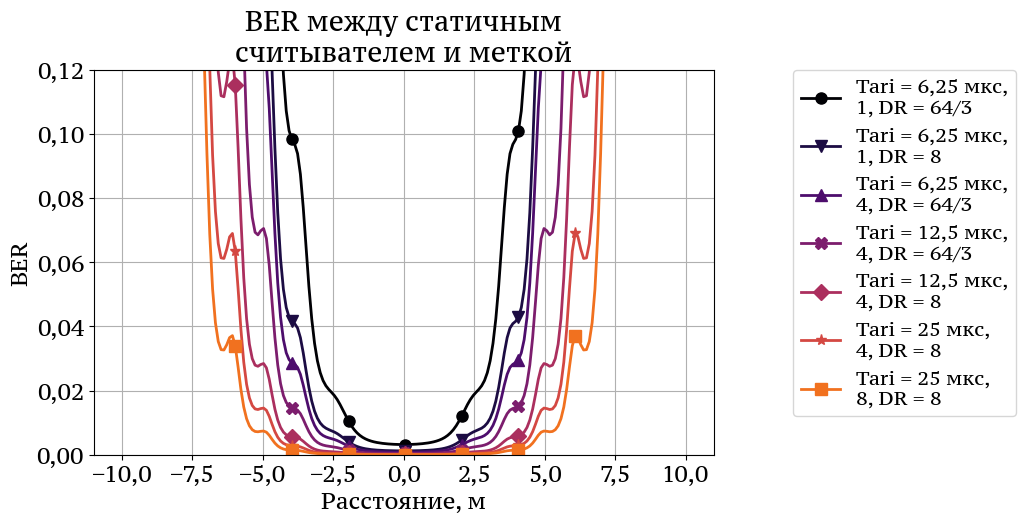

In [21]:
def plot_ber(
    image_name: str = 'Static BER', save_fig: bool = False
) -> None:
    """
    Нарисовать график зависимости BER от расстояния между 
    считывателем и меткой.
    
    Args:
        image_name (str): имя файла без расширения
        save_fig: сохранить ли изображение
    """
    # Задание областей моделирования
    ox_axis = np.linspace(MINIMUM_DISTANCE+D_SHIFT, MAXIMUM_DISTANCE-D_SHIFT, GRID_STEP)
    tag_accepted_power = [get_tag_rx(x, v=0, t=0) for x in ox_axis]
    tag_radiated_power = [get_tag_tx(power) for power in tag_accepted_power]
    reader_accepted_power = [get_reader_rx(x, v=0, t=0, power=tag_power)
                             for (x, tag_power) in zip(ox_axis, tag_radiated_power)]
    fig, ax = plt.subplots(figsize=GraphConsts.FIGSIZE, nrows=1, ncols=1)

    for i, (tari_us, m, dr) in enumerate(SERIES):
        # Получение результатов
        tari = tari_us * 1e-6
        trcal = epc.get_trcal(tari)
        m_tag_value = m.value[1] # пример m.value: ('10', 4, 'M4')
        snr_on_reader = [get_snr(power, m_tag_value, trcal, False, dr) for power in reader_accepted_power]
        ber_on_reader = [channel.ber(snr) for snr in snr_on_reader]

        # Построение кривых
        props = {
            'marker': SERIES_MARKERS[i], 
            'color': SERIES_COLORS[i],
            'markevery': GraphConsts.MARKEVERY, 
            'label': (f'Tari = {tari_us:n} мкс,\n'
                      f'{m_tag_value}, DR = {str(dr)}')
        } 
        ax.plot(ox_axis, ber_on_reader, **props)
        
    # Оформление графика
    ax.set_title('BER между статичным\nсчитывателем и меткой')
    ax.set_xlabel('Расстояние, м')
    ax.set_ylabel('BER')
    ax.set_ylim((0, 0.12)) # Выше строить нет смысла
    ax.grid()
    fig.legend(loc='center right', bbox_to_anchor=(1.29, 0.533))

    if save_fig:
        savefig(name=image_name, directory=DIRECTORY)

plot_ber(save_fig = True)

### 🌀 Учёт эффекта Доплера для BER

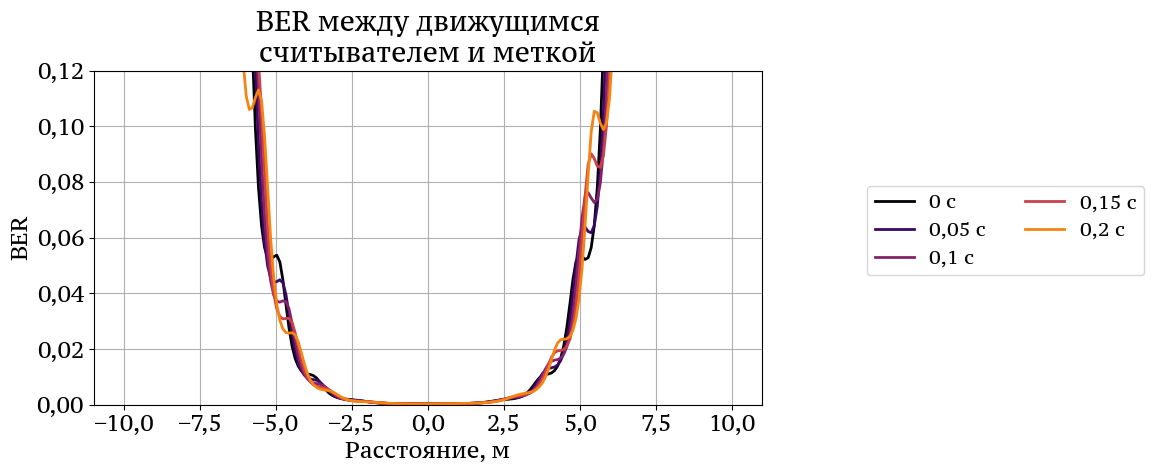

In [22]:
def plot_ber_doppler( 
    m_tag_value: int = epc.TagEncoding.M2.value[1], 
    tari_us: float = 12.5,
    image_name: str = 'Dopler BER',
    save_fig: bool = False,
) -> None:
    """
    Нарисовать график BER от расстояния по земле с учетом эффекта Доплера.
    
    Args:
        m_tag_value (int): число символов на бит в ответе метки (1, 2, 4, 8)
        tari_us (float): величина Tari в микросекундах (по-умолчанию, 12.5)
        image_name (str): имя файла без расширения
        save_fig: сохранить ли изображение
    """
    # Задание областей моделирования
    ox_axis = np.linspace(MINIMUM_DISTANCE+D_SHIFT, MAXIMUM_DISTANCE-D_SHIFT, GRID_STEP)
    time_points = np.linspace(MINIMUM_TIME, MAXIMUM_TIME, DOPPLER_LINES_COUNT)
    speed = channel.kmph2mps(DEFAULT_SPEED)
    fig, ax = plt.subplots(figsize=GraphConsts.FIGSIZE, nrows=1, ncols=1)
    
    tari = tari_us * 1e-6
    trcal = epc.get_trcal(tari)
    
    for i, t in enumerate(time_points):
        # Получение результатов
        tag_accepted_power = [get_tag_rx(x, v=speed, t=t) for x in ox_axis]
        tag_tx = [get_tag_tx(rx) for rx in tag_accepted_power]
        reader_accepted_power = [get_reader_rx(x, v=speed, t=t, power=power) for (x, power) in zip(ox_axis, tag_tx)]
        snr_on_reader = [get_snr(power, m_tag_value, trcal, False) for power in reader_accepted_power]
        ber = [channel.ber(snr) for snr in snr_on_reader]

        # Построение кривых
        color = get_color(i / (len(time_points) * 1.1))
        ax.plot(ox_axis, ber, label=f"{t:n} с", color=color)

    # Оформление графика
    ax.grid()
    ax.set_title('BER между движущимся\nсчитывателем и меткой')
    ax.set_ylabel('BER')
    ax.set_xlabel('Расстояние, м')
    ax.set_ylim((0, 0.12)) # Выше строить нет смысла
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
               bbox_to_anchor=(1.46, 0.51), ncol=2) 
    plt.tight_layout()

    if save_fig:
        savefig(name=image_name, directory=DIRECTORY)

plot_ber_doppler(save_fig = True)